<img src='../img/dust_banner.png' alt='Training school and workshop on dust' align='center' width='100%'></img>

<br>

# Day 2 - Assignment - Solution

### About

> So far, we analysed Aerosol Optical Depth from different types of data (satellite, model-based and observations) for a single dust event. Let us now broaden our view and analyse the annual cycle in 2020 of Aerosol Optical Depth from AERONET and compare it with the CAMS global reanalysis data.

### Tasks

#### 1. Download and plot time-series of AERONET data for Santa Cruz, Tenerife in 2020
  * **Hint** 
    * [AERONET - Example notebook](../../dust_workshop_part1/02_ground-based_observations/21_AERONET.ipynb)
    * you can select daily aggregates of the station observations with setting `AVG=20`
  * **Interpret the results:**
    * Have there been other times in 2020 with increased AOD values?
    * If yes, how could you find out if the increase in AOD is caused by dust? Try to find out by visualizing the AOD time-series together with another parameter from the AERONET data.
    * [MSG SEVIRI Dust RGB](https://sds-was.aemet.es/forecast-products/dust-observations/msg-2013-eumetsat) and [MODIS RGB](https://worldview.earthdata.nasa.gov/) quick looks might be helpful to get a more complete picture of other events that might have happened in 2020.


#### 2. Download CAMS global reanalysis (EAC4) and select 2020 time-series for *Santa Cruz, Tenerife*
  * **Hint**
    * [CAMS global forecast - Example notebook](../../dust_workshop_part1/03_model-based_data/32_CAMS_global_forecast_duaod_load_browse.ipynb) (**Note:** the notebook works with CAMS forecast data, but they have a similar data structure to the CAMS global reanalysis data)
    * [Data access](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form) with the following specifications:
    > Variable on single levels: `Dust aerosol optical depth at 550 nm` <br>
    > Date: `Start=2020-01-01`, `End=2020-12-31` <br>
    > Time: `[00:00, 03:00, 06:00, 09:00, 12:00, 15:00, 18:00, 21:00]` <br>
    > Restricted area: `N: 30., W: -20, E: 14, S: 20.` <br>
    >Format: `netCDF` <br>
    * With the xarray function `sel()` and keyword argument `method='nearest'` you can select data based on coordinate information
    * We also recommend you to transform your xarray.DataArray into a pandas.DataFrame with the function `to_dataframe()`
    

#### 3. Visualize both time-series of CAMS reanalysis and AERONET daily aggregates in one plot
  * **Interpret the results:** What can you say about the annual cycle in 2020 of AOD in Santa Cruz, Tenerife?

### Module outline
* [1 - Select latitude / longitude values for Santa Cruz, Tenerife](#select_lat_lon)
* [2 - Download and plot time-series of AERONET data](#aeronet)
* [3 - Download CAMS global reanalysis (EAC4) and select 2020 time-series for Santa Cruz, Tenerife](#cams_reanalysis)
* [4 - Combine both annual time-series and visualize both in one plot](#visualize_annual_ts)


<hr>

##### Load required libraries

In [2]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import wget

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [3]:
%run ../functions.ipynb

<hr>

### <a id='select_lat_lon'></a>1. Select latitude / longitude values for Santa Cruz, Tenerife

You can see an overview of all available AERONET Site Names [here](https://aeronet.gsfc.nasa.gov/cgi-bin/draw_map_display_aod_v3?long1=-180&long2=180&lat1=-90&lat2=90&multiplier=2&what_map=4&nachal=1&formatter=0&level=3&place_code=10&place_limit=0).

In [3]:
lat = 28.473
lon = -16.247

<br>

### <a id='aeronet'></a>2. Download and plot time-series of AERONET data

As a first step, let us create a Python dictionary in which we store all the parameters we would like to use for the request as dictionary keys. You can initiate a dictionary with curled brackets `{}`. Below, we specify the following parameters:
* `endpoint`: Endpoint of the AERONET web service
* `station`: Name of the AERONET station
* `year`: year 1 of interest
* `month`: month 1 of interest
* `day`: day 1 of interest
* `year2`: year 2 of interest
* `month2`: month 2 of interest
* `day2`: day 2 of interest
* `AOD15`: data type, other options include `AOD10`, `AOD20`, etc.
* `AVG`: data format, `AVG=10` - all points, `AVG=20` - daily averages

The keywords below are those we will need for requesting daily averaged observations of Aerosol Optical Depth Level 1.5 data for the station Santa Cruz, Tenerife from 1 January to 31 December 2020.

In [7]:
data_dict = {
    'endpoint': 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3',
    'station':'Santa_Cruz_Tenerife',
    'year': 2020,
    'month': 1,
    'day': 1,
    'year2': 2020,
    'month2': 12,
    'day2': 31,
    'AOD15': 1,
    'AVG': 20
}


In a next step, we construct the final string for the wget request with the `format` function. You construct a string by adding the dictionary keys in curled brackets. At the end of the string, you provide the dictionary key informatoin to the string with the `format()` function. A print of the resulting url shows, that the format function replaced the information in the curled brackets with the data in the dictionary.

In [8]:
url = '{endpoint}?site={station}&year={year}&month={month}&day={day}&year2={year2}&month2={month2}&day2={day2}&AOD15={AOD15}&AVG={AVG}'.format(**data_dict)
url

'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=Santa_Cruz_Tenerife&year=2020&month=1&day=1&year2=2020&month2=12&day2=31&AOD15=1&AVG=20'

<br>

Now we are ready to request the data with the function `download()` from the wget Python library. You have to pass to the function the constructed url above together with a file path of where the downloaded that shall be stored. Let us store the data as `txt` file in the folder `../data/2_observations/aeronet/`.

In [9]:
wget.download(url, '../data/aeronet/2020_santa_cruz_tenerife_20.txt')

'../data/aeronet/2020_santa_cruz_tenerife_20 (1).txt'

<br>

After we downloaded the station observations as `txt` file, we can open it with the pandas function `read_table()`. We additonally set specific keyword arguments that allow us to specify the columns and rows of interest:
* `delimiter`: specify the delimiter in the text file, e.g. comma
* `header`: specify the index of the row that shall be set as header.
* `index_col`: specify the index of the column that shall be set as index

You see below that the resulting dataframe has 296 rows and 81 columns.

In [4]:
df = pd.read_table('../data/aeronet/2020_santa_cruz_tenerife_20.txt', delimiter=',', header=[7], index_col=1)
df

,AERONET_Site,Time(hh:mm:ss),Day_of_Year,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,...,N[440-675_Angstrom_Exponent],N[500-870_Angstrom_Exponent],N[340-440_Angstrom_Exponent],N[440-675_Angstrom_Exponent[Polar]],Data_Quality_Level,AERONET_Instrument_Number,AERONET_Site_Name,Site_Latitude(Degrees),Site_Longitude(Degrees),Site_Elevation(m)<br>
Date(dd:mm:yyyy),,,,,,,,,,,,,,,,,,,,,
01:01:2020,Santa_Cruz_Tenerife,12:00:00,1.0,0.061198,0.076232,0.080599,-999.0,-999.0,0.085592,-999.0,...,87.0,87.0,87.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
03:01:2020,Santa_Cruz_Tenerife,12:00:00,3.0,0.039688,0.052219,0.056409,-999.0,-999.0,0.063661,-999.0,...,131.0,131.0,131.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
04:01:2020,Santa_Cruz_Tenerife,12:00:00,4.0,0.046246,0.058887,0.063752,-999.0,-999.0,0.073848,-999.0,...,39.0,39.0,39.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
05:01:2020,Santa_Cruz_Tenerife,12:00:00,5.0,0.039780,0.050607,0.055417,-999.0,-999.0,0.065148,-999.0,...,59.0,59.0,58.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
06:01:2020,Santa_Cruz_Tenerife,12:00:00,6.0,0.025086,0.033686,0.037128,-999.0,-999.0,0.042951,-999.0,...,33.0,33.0,32.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28:12:2020,Santa_Cruz_Tenerife,12:00:00,363.0,0.281631,0.361706,0.378314,-999.0,-999.0,0.398796,-999.0,...,95.0,95.0,95.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
29:12:2020,Santa_Cruz_Tenerife,12:00:00,364.0,0.225135,0.279970,0.290588,-999.0,-999.0,0.304814,-999.0,...,35.0,35.0,35.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
30:12:2020,Santa_Cruz_Tenerife,12:00:00,365.0,0.055233,0.075359,0.079524,-999.0,-999.0,0.086272,-999.0,...,34.0,34.0,34.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>


Now, we can inspect the entries in the loaded data frame a bit more. Above you see that the last entry is a NaN entry, which is best to drop with the function `dropna()`.

The next step is then to replace the entries with -999.0 and set them as NaN. We can use the function `replace()` to do so. 

In [5]:
df = df.dropna()
df = df.replace(-999.0, np.nan)
df

,AERONET_Site,Time(hh:mm:ss),Day_of_Year,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,...,N[440-675_Angstrom_Exponent],N[500-870_Angstrom_Exponent],N[340-440_Angstrom_Exponent],N[440-675_Angstrom_Exponent[Polar]],Data_Quality_Level,AERONET_Instrument_Number,AERONET_Site_Name,Site_Latitude(Degrees),Site_Longitude(Degrees),Site_Elevation(m)<br>
Date(dd:mm:yyyy),,,,,,,,,,,,,,,,,,,,,
01:01:2020,Santa_Cruz_Tenerife,12:00:00,1.0,0.061198,0.076232,0.080599,NaN,NaN,0.085592,NaN,...,87.0,87.0,87.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
03:01:2020,Santa_Cruz_Tenerife,12:00:00,3.0,0.039688,0.052219,0.056409,NaN,NaN,0.063661,NaN,...,131.0,131.0,131.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
04:01:2020,Santa_Cruz_Tenerife,12:00:00,4.0,0.046246,0.058887,0.063752,NaN,NaN,0.073848,NaN,...,39.0,39.0,39.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
05:01:2020,Santa_Cruz_Tenerife,12:00:00,5.0,0.039780,0.050607,0.055417,NaN,NaN,0.065148,NaN,...,59.0,59.0,58.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
06:01:2020,Santa_Cruz_Tenerife,12:00:00,6.0,0.025086,0.033686,0.037128,NaN,NaN,0.042951,NaN,...,33.0,33.0,32.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27:12:2020,Santa_Cruz_Tenerife,12:00:00,362.0,0.087975,0.114314,0.119534,NaN,NaN,0.125963,NaN,...,80.0,80.0,80.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
28:12:2020,Santa_Cruz_Tenerife,12:00:00,363.0,0.281631,0.361706,0.378314,NaN,NaN,0.398796,NaN,...,95.0,95.0,95.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
29:12:2020,Santa_Cruz_Tenerife,12:00:00,364.0,0.225135,0.279970,0.290588,NaN,NaN,0.304814,NaN,...,35.0,35.0,35.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>


Let us now convert the index entry to a `DateTimeIndex` format with the function `to_datetime()`. Important here, you have to specify the format of the index string: `%d:%m:%Y`.

You see below that we do not have observations for every day. E.g on 2 January 2020, the data frame does not list any entry.

In [6]:
df.index = pd.to_datetime(df.index, format = '%d:%m:%Y')
df

,AERONET_Site,Time(hh:mm:ss),Day_of_Year,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,...,N[440-675_Angstrom_Exponent],N[500-870_Angstrom_Exponent],N[340-440_Angstrom_Exponent],N[440-675_Angstrom_Exponent[Polar]],Data_Quality_Level,AERONET_Instrument_Number,AERONET_Site_Name,Site_Latitude(Degrees),Site_Longitude(Degrees),Site_Elevation(m)<br>
Date(dd:mm:yyyy),,,,,,,,,,,,,,,,,,,,,
2020-01-01,Santa_Cruz_Tenerife,12:00:00,1.0,0.061198,0.076232,0.080599,NaN,NaN,0.085592,NaN,...,87.0,87.0,87.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
2020-01-03,Santa_Cruz_Tenerife,12:00:00,3.0,0.039688,0.052219,0.056409,NaN,NaN,0.063661,NaN,...,131.0,131.0,131.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
2020-01-04,Santa_Cruz_Tenerife,12:00:00,4.0,0.046246,0.058887,0.063752,NaN,NaN,0.073848,NaN,...,39.0,39.0,39.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
2020-01-05,Santa_Cruz_Tenerife,12:00:00,5.0,0.039780,0.050607,0.055417,NaN,NaN,0.065148,NaN,...,59.0,59.0,58.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
2020-01-06,Santa_Cruz_Tenerife,12:00:00,6.0,0.025086,0.033686,0.037128,NaN,NaN,0.042951,NaN,...,33.0,33.0,32.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,Santa_Cruz_Tenerife,12:00:00,362.0,0.087975,0.114314,0.119534,NaN,NaN,0.125963,NaN,...,80.0,80.0,80.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
2020-12-28,Santa_Cruz_Tenerife,12:00:00,363.0,0.281631,0.361706,0.378314,NaN,NaN,0.398796,NaN,...,95.0,95.0,95.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>
2020-12-29,Santa_Cruz_Tenerife,12:00:00,364.0,0.225135,0.279970,0.290588,NaN,NaN,0.304814,NaN,...,35.0,35.0,35.0,0.0,lev15,1090.0,Santa_Cruz_Tenerife,28.472528,-16.247361,52.000000<br>


<br>

We can now plot the column `AOD_500nm` as annual time-series. You see that the station `Santa Cruz, Tenerife` was affected by other dust events later in 2020.

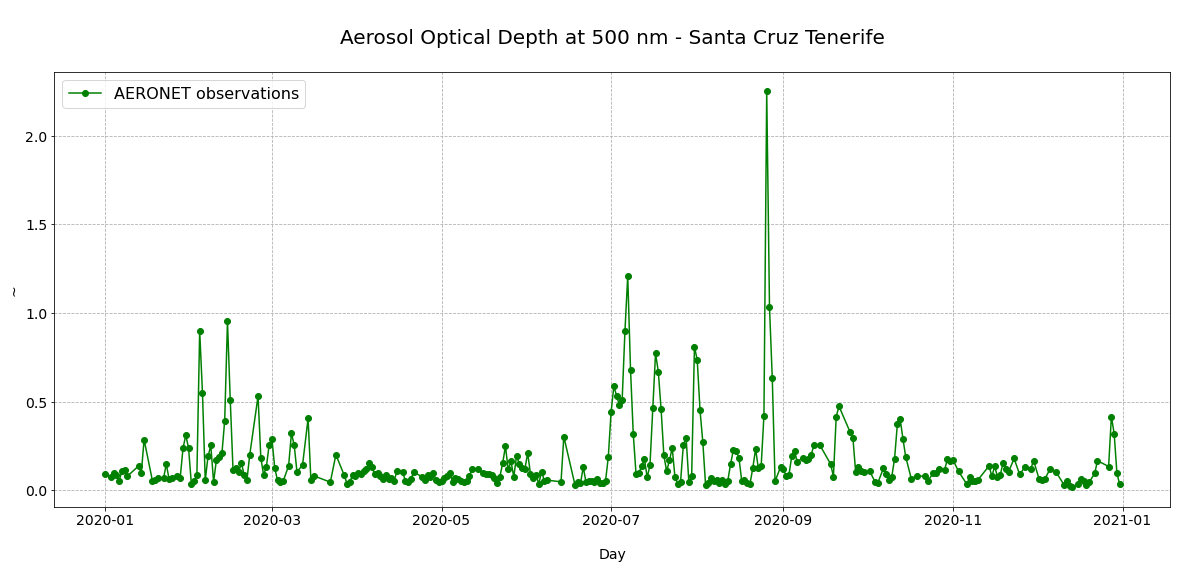

In [7]:
# Initiate a figure
fig = plt.figure(figsize=(20,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(df.AOD_500nm, 'o-', color='green', label='AERONET observations')

# Customize the title and axes lables
ax.set_title('\nAerosol Optical Depth at 500 nm - Santa Cruz Tenerife\n', fontsize=20)
ax.set_ylabel('~', fontsize=14)
ax.set_xlabel('\nDay', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

plt.legend(fontsize=16, loc=2)


<br>

The next question is now, how you can find out, if the strong increase of AOD at the end of August 2020 was because of dust? For this to find out, you can use the `Angstrom Exponent`, which gives us an indication of the particle size. If the `Angstrom Exponent` is below 0.6, then it is an indication that the increase of AOD is caused by coarser dust particles.

Let us visualize the AOD at 500nm for 2020 together with the `Angstrom Exponent 440-675nm`.

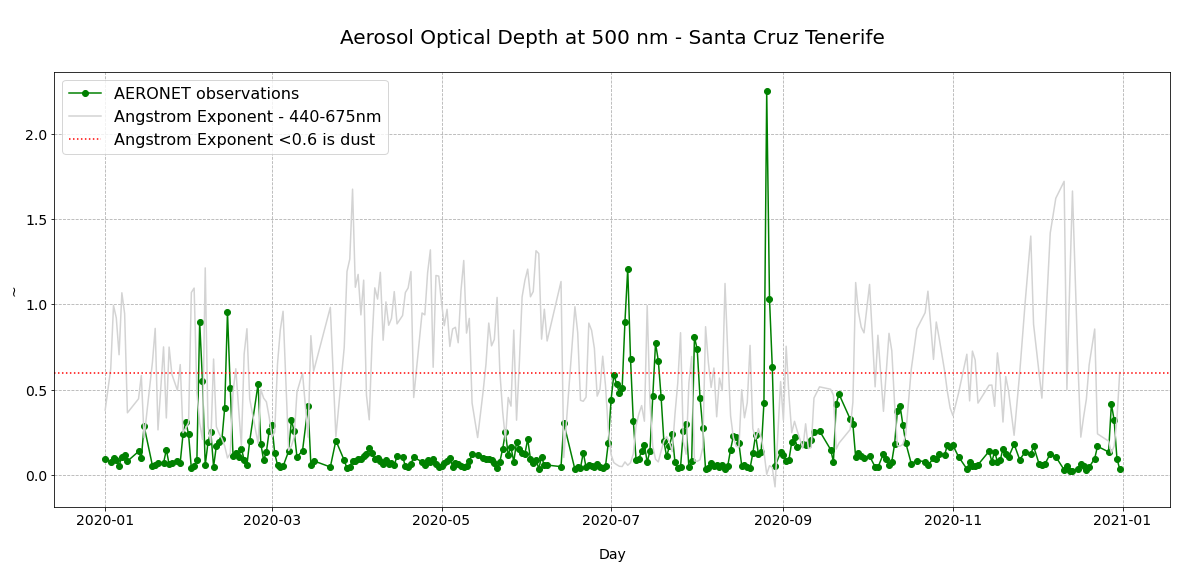

In [9]:
# Initiate a figure
fig = plt.figure(figsize=(20,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(df.AOD_500nm, 'o-', color='green', label='AERONET observations')
ax.plot(df['440-675_Angstrom_Exponent'], '-', color='lightgrey', label='Angstrom Exponent - 440-675nm')

plt.axhline(y=0.6, color='r', linestyle='dotted', label='Angstrom Exponent <0.6 is dust')

# Customize the title and axes lables
ax.set_title('\nAerosol Optical Depth at 500 nm - Santa Cruz Tenerife\n', fontsize=20)
ax.set_ylabel('~', fontsize=14)
ax.set_xlabel('\nDay', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

plt.legend(fontsize=16, loc=2)

Above, you see that the Angstrom Exponent during the high AOD values at the end of August is very low. Hence, we could interpret this event as a strong dust intrusion. But is this really the case? You can also check [here](https://sds-was.aemet.es/forecast-products/dust-observations/msg-2013-eumetsat) the MSG SEVIRI Dust RGB for e.g. 26 August 2020 and [here](https://worldview.earthdata.nasa.gov/?v=-39.451155087380556,13.025874527486357,5.067364489712844,36.350274677008436&l=Reference_Labels_15m(hidden),Reference_Features_15m(hidden),Coastlines_15m,MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor&lg=false&t=2020-08-26-T00%3A00%3A00Z) the MODIS RGB to better understand the event and what could have caused the high AOD values.

<br>

### <a id='cams_reanalysis'></a> 3. Download CAMS global reanalysis (EAC4) and select 2020 time-series for Santa Cruz, Tenerife

First, we have to download the `CAMS global reanalysis (EAC4)` from the [Copernicus Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form) with the following specifications:
* Variable on single levels: `Dust aerosol optical depth at 550 nm`
* Date: `Start=2020-01-01`, `End=2020-12-31`
* Time: `[00:00, 03:00, 06:00, 09:00, 12:00, 15:00, 18:00, 21:00]`
* Restricted area: `N: 30., W: -20, E: 14, S: 20.`
* Format: `netCDF`

See `CDSAPI` request below.

In [9]:
URL = 'https://ads.atmosphere.copernicus.eu/api/v2'
KEY = '######################'

In [ ]:
import cdsapi

c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'cams-global-reanalysis-eac4',
    {
        'variable': 'dust_aerosol_optical_depth_550nm',
        'date': '2020-01-01/2020-12-31',
        'time': [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
        ],
        'area': [
            30, -20, 20,
            15,
        ],
        'format': 'netcdf',
    },
    '../data/cams/2020_dustAOD_cams_eac4.nc'}

<br>

The data is in netCDF, so we can open the netCDF file with the xarray function `open_dataset()`. We see that the data has three dimensions (`latitude`, `longitude`, `time`) and one data variable:
* `duaod550`: Dust Aerosol Optical Depth at 550nm

In [14]:
file = xr.open_dataset('../data/cams/2020_dustAOD_cams_eac4.nc')
file

<xarray.Dataset>
Dimensions:    (longitude: 47, latitude: 14, time: 2928)
Coordinates:
  * longitude  (longitude) float32 -20.0 -19.25 -18.5 -17.75 ... 13.0 13.75 14.5
  * latitude   (latitude) float32 29.75 29.0 28.25 27.5 ... 21.5 20.75 20.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T21:00:00
Data variables:
    duaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-10 14:13:05 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

<br>

Let us now store the data variable `Dust Aerosol Optical Depth (AOD) at 550nm` as `xarray.DataArray` with the name `duaod_cams`.

In [15]:
duaod_cams = file['duaod550']
duaod_cams

<xarray.DataArray 'duaod550' (time: 2928, latitude: 14, longitude: 47)>
[1926624 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -20.0 -19.25 -18.5 -17.75 ... 13.0 13.75 14.5
  * latitude   (latitude) float32 29.75 29.0 28.25 27.5 ... 21.5 20.75 20.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T21:00:00
Attributes:
    units:      ~
    long_name:  Dust Aerosol Optical Depth at 550nm

<br>

Now, we can select the time-series of the grid point nearest to the station in Santa Cruz, Tenerife. We can use the function `sel()` to select data based on the longitude and latitude dimensions. The keyword argument `method='nearest'` selects the grid point entry closest to the station coordinates.

In [18]:
cams_ts = duaod_cams.sel(longitude=lon, latitude=lat, method='nearest')
cams_ts

<xarray.DataArray 'duaod550' (time: 2928)>
array([0.007244, 0.021985, 0.060917, ..., 0.005728, 0.004677, 0.003822],
      dtype=float32)
Coordinates:
    longitude  float32 -16.25
    latitude   float32 28.25
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T21:00:00
Attributes:
    units:      ~
    long_name:  Dust Aerosol Optical Depth at 550nm

<br>

The next step is now to resample the 3-hourly time entries and aggregate it to daily averages. We can use a combination of the functions `resample()` and `mean()` to create daily averages.

In [19]:
cams_ts_resample = cams_ts.resample(time='1D').mean()
cams_ts_resample

<xarray.DataArray 'duaod550' (time: 366)>
array([6.26771897e-02, 1.21897265e-01, 6.45051599e-02, 6.81166351e-03,
       1.11380219e-03, 2.36323476e-03, 1.70692801e-03, 2.12018192e-03,
       2.59661674e-03, 1.27915293e-02, 2.31949985e-03, 1.18672848e-03,
       6.82000369e-02, 9.66019481e-02, 1.06641322e-01, 5.51756322e-02,
       6.65611029e-03, 3.57866287e-03, 5.35264611e-04, 5.40107489e-04,
       1.26868486e-04, 2.28971243e-04, 5.88308275e-03, 7.26868212e-03,
       6.05811179e-03, 4.26903367e-03, 1.19990855e-02, 9.62656736e-03,
       8.38011652e-02, 1.65890560e-01, 1.58602878e-01, 6.69117123e-02,
       4.65308130e-03, 7.19046295e-02, 3.36282521e-01, 3.49263191e-01,
       8.95184875e-02, 6.27355129e-02, 1.27191618e-01, 1.28401518e-02,
       2.42699534e-02, 7.66301751e-02, 1.55321255e-01, 2.17939615e-01,
       4.48830277e-01, 3.32869619e-01, 6.46899045e-02, 5.61430752e-02,
       2.86746323e-02, 1.25387311e-02, 2.85427272e-03, 4.57480550e-04,
       1.68058857e-01, 7.46165454e-01, 5.34614563e-01, 4.31294233e-01,
       1.71836376e-01, 5.27052581e-03, 2.51790732e-02, 1.20623484e-01,
       1.22927919e-01, 5.87635338e-02, 9.09666717e-03, 1.24505162e-03,
       9.78703797e-03, 1.80081427e-02, 3.58837843e-03, 1.31649762e-01,
       1.49847046e-01, 5.58611155e-02, 8.08890164e-02, 1.23239055e-01,
       1.12538531e-01, 1.09684721e-01, 2.63993740e-02, 5.64485788e-03,
       1.56059861e-04, 5.24136424e-03, 1.17954418e-01, 1.49613649e-01,
...
       1.51704177e-01, 9.84493941e-02, 4.13101166e-02, 2.73425579e-02,
       4.11496758e-02, 9.22799408e-02, 2.60631740e-03, 1.46314502e-04,
       1.17123127e-04, 8.80983472e-03, 8.88815969e-02, 9.45503116e-02,
       3.46885324e-02, 3.57580930e-02, 4.34055179e-02, 9.80604440e-02,
       2.00432733e-01, 8.51429701e-02, 5.67653924e-02, 8.52298737e-03,
       4.79409099e-03, 3.50505114e-04, 1.65790319e-04, 5.30421734e-04,
       9.14469361e-04, 1.81388855e-03, 5.34346700e-03, 2.23447382e-02,
       2.38129646e-02, 5.62014282e-02, 1.12864256e-01, 6.75437450e-02,
       1.27838194e-01, 6.38682693e-02, 5.41449189e-02, 5.96240610e-02,
       5.70862293e-02, 7.16469884e-02, 3.21166962e-02, 5.39456010e-02,
       1.17779389e-01, 7.62315542e-02, 5.20691276e-04, 5.88297844e-05,
       1.17167830e-04, 3.99127603e-04, 8.31186771e-05, 3.01882625e-04,
       3.35916877e-04, 1.56059861e-04, 1.38117373e-03, 3.31127644e-03,
       3.93986702e-05, 7.88062811e-04, 3.60235572e-04, 2.97054648e-04,
       2.97039747e-04, 2.58132815e-04, 6.32479787e-04, 6.32479787e-04,
       3.45647335e-04, 1.31756067e-04, 4.42564487e-05, 1.07407570e-04,
       1.12280250e-04, 1.02549791e-04, 1.26838684e-04, 7.34031200e-05,
       1.72642767e-02, 1.09888896e-01, 2.62545496e-01, 3.42311025e-01,
       9.04908031e-02, 6.92404509e-02, 2.15455323e-01, 1.82337582e-01,
       7.28429556e-02, 1.04822367e-02], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
    longitude  float32 -16.25
    latitude   float32 28.25

<br>

A closer look at the `time` dimension shows us that we now have an entry for each day in 2020.

In [20]:
cams_ts_resample.time

<xarray.DataArray 'time' (time: 366)>
array(['2020-01-01T00:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-03T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
    longitude  float32 -16.25
    latitude   float32 28.25

<br>

Now, we can convert the `xarray.DataArray` to a `pandas.DataFrame`, as pandas is more efficient to handle time-series data. The function `to_dataframe()` easily converts a data array to a dataframe. The resulting dataframe has 366 rows and 3 columns.

In [21]:
cams_ts_df = cams_ts_resample.to_dataframe()
cams_ts_df

,longitude,latitude,duaod550
time,,,
2020-01-01,-16.25,28.25,0.062677
2020-01-02,-16.25,28.25,0.121897
2020-01-03,-16.25,28.25,0.064505
2020-01-04,-16.25,28.25,0.006812
2020-01-05,-16.25,28.25,0.001114
...,...,...,...
2020-12-27,-16.25,28.25,0.069240
2020-12-28,-16.25,28.25,0.215455
2020-12-29,-16.25,28.25,0.182338


<br>

### <a id='visualize_annual_ts'></a>4. Combine both annual time-series and visualize both in one plot

Let us now use the function `join()` and combine the two time-series `cams_ts_df` and `df['AOD_500nm]`. The resulting dataframe has 366 rows and 4 columns.

In [24]:
df_combined = cams_ts_df.join(df['AOD_500nm'])
df_combined

,longitude,latitude,duaod550,AOD_500nm
time,,,,
2020-01-01,-16.25,28.25,0.062677,0.094487
2020-01-02,-16.25,28.25,0.121897,NaN
2020-01-03,-16.25,28.25,0.064505,0.075765
2020-01-04,-16.25,28.25,0.006812,0.098110
2020-01-05,-16.25,28.25,0.001114,0.085672
...,...,...,...,...
2020-12-27,-16.25,28.25,0.069240,0.134366
2020-12-28,-16.25,28.25,0.215455,0.415433
2020-12-29,-16.25,28.25,0.182338,0.320463


Let us safe the pandas dataframe as csv file. This allows us to easily load the time-series again at a later stage. You can use the function `to_csv()` to save a pandas.DataFrame as csv.

In [33]:
df_combined.to_csv("../data/2020_ts_cams_aeronet.csv", index_label='time')

<br>

The last step is now to plot the two columns of the pandas.DataFrame `df_combined` as two individual line plots.

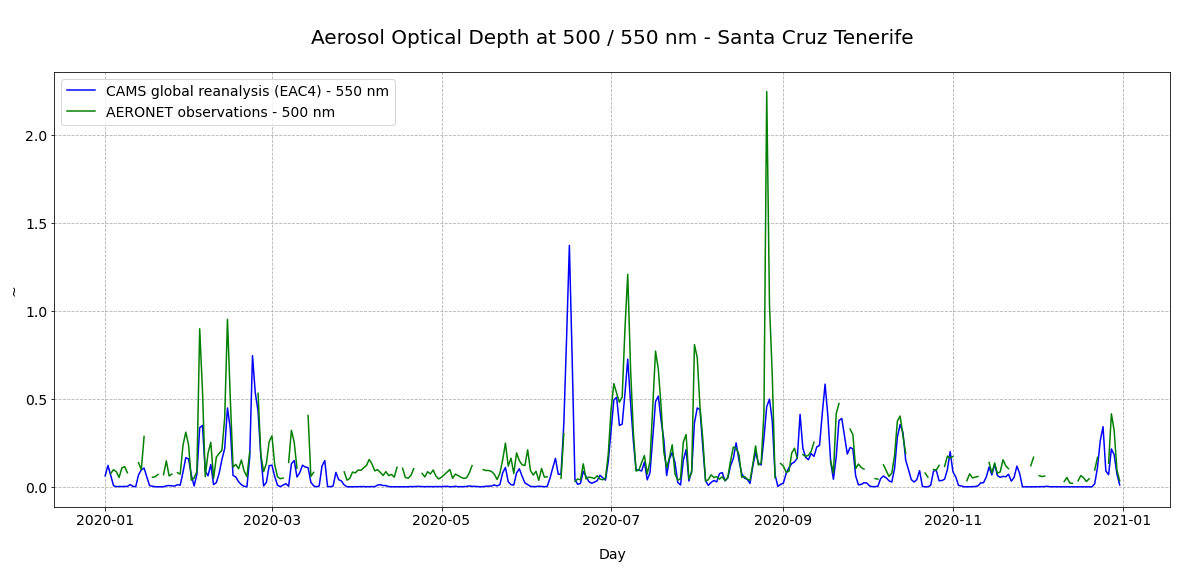

In [23]:
# Initiate a figure
fig = plt.figure(figsize=(20,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(df_combined.duaod550, '-', color='blue', label='CAMS global reanalysis (EAC4) - 550 nm')
ax.plot(df_combined.AOD_500nm, '-', color='green', label='AERONET observations - 500 nm')
plt.axhline(y=0.6, color='r', linestyle='dotted', label='PM10 daily limit')

# Customize the title and axes lables
ax.set_title('\nAerosol Optical Depth at 500 / 550 nm - Santa Cruz Tenerife\n', fontsize=20)
ax.set_ylabel(cams_ts.units, fontsize=14)
ax.set_xlabel('\nDay', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

plt.legend(fontsize=14, loc=2)


<br>

You see in the plot above that the model and the AERONET observations follow a similar annual cycle of AOD in 2020 for the Santa Cruz station in Tenerife. You also see that for higher AOD values measured by AERONET, the CAMS model mostly underpredicts the AOD intensity.

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='left' width='20%'><br><br><br><br>
<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.